---
# Banco de datos
---

In [1]:
# CAMBIOS: 

#Cambio 1
# se añadela variable mc_st en la ceda de parámetros de usuario, esta nos permite introducir el número de clusteres que deseamos crear una vez que se pueda analizar la stm.

#Cambio 2:
# Se agrega la cadena= base2 para identificar más facilmente los archivos de tiempo que se generen en esta versión.
# De la biblioteca timeit se importa default_timer como timer
# Se crea un data frame para guardar los tiempos que lleva cada proceso y saber en cuál tarda más.

#Cambio 3:
# Se eliminan las siguientes funciones: matrix_similarity_clusters y values
# Se crea la funcion g_h_o_s que reemplaza a las funciones eliminadas

# Cambio 4: 
# Ya no se mide el tiempo de la matriz GHOS porque ya no se hace.
# Se miden los tiempos en la STM para ver dónde se tarda más.
# Se tarda más en la función Analysis.
# Se miden los tiempos dentro de la función de Analysis para saber donde se tarda más.
# Se tarda más en A6

# Cambio 5 
# La siguiente línea se cambia ya que el método de append está obsoleto y será removido en futuras versiones. Este:
# globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)] = globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)].append(X_test)
# Por este: globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)] = pd.concat((globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)], X_test), axis = 0)

# short_classes = short_classes.append(y_test.to_frame())  -- short_classes = pd.concat((short_classes, y_test.to_frame()), axis = 0)
# short_term_memory = short_term_memory.append(X_test) -- short_term_memory = pd.concat((short_term_memory, X_test), axis = 0)

Importing libraries.

In [2]:
import pandas as pd
import numpy as np
import math
# Bibliotecas para hacer clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.model_selection import LeaveOneOut
from statistics import mean 
from datetime import datetime #Ayuda a contar el tiempo de análisis en la ventana

# import collections
from itertools import groupby
# importar un "cronómetro"
from timeit import default_timer as timer
# Para mostrar barra de progreso:
#!pip install tqdm -q # Este ya esta instalado 
import time
from tqdm.notebook import tqdm_notebook
# Las siguientes línea: seaborn es para visualizar la amtriz de confusión
import seaborn as sn

In [3]:
#S = pd.read_csv('C:/Users/super/OneDrive - Instituto Politecnico Nacional/TESIS Karen/Bancos/normal2000_smurf2000_neptune.csv')
S = pd.read_csv('C:/Users/Karen Pamela/OneDrive - Instituto Politecnico Nacional/TESIS Karen/Bancos/normal2000_smurf2000_neptune.csv')

cadena = 'base6_recurrent'

In [4]:
# S = S[:round(len(S.index)*.1)]
S = S[:10000] # 42000 #62000 # 980

# Parámetros de usuario

In [5]:
# Preguntar si la clase es numérica o categórica. 
# class_type lo usa preprocessing_label_coding function
class_type = 'c' #input('Is the class numeric "n" or categorical "c"? ')
# Introduce the instances for training the model
InitNumber = 2000 #int(input("Introduce the InitNumber: "))
# Introduce the instances for the step window
paso = 2000 #int(input("Window size: "))
# Introduce the instances for the short term memory
n_elements_stm = 100 # 50 o 100
# Introduce el numero de instancias para determinar si un cluster es válido
n_representative = 20
# Al Timestamp actual se le resta ventana_de_olvido para que instancias mas viejas
# que esa diferencia se eliminen 
ventana_de_olvido = 2000 # más grande
#paso * 0.5 # Ventana para no tener instancias viejas en el short_term_memory
mc_stm = 10 # Número de clústeres que se harán en la stm
opc_clasif = 2 #input("Como realizar la clasificación? \n '1': si la clasificación es correcta se añade al mc, \n '2': si cumple con un umbral de similitud se añade al mc\n ")
Umbral_similarity = 32
#if opc_clasif == 2:
#    Umbral_similarity = input("Ingresa la similaridad del umbral (de 1 a 4 ): ")

---
# Modulos
---

# LABEL CODING

The following function is for convert categoric attributes to label coding.

Ordenate the dataframe as follows: label coding columns, numeric columns and CLASS columns.

The function returns:
- Preprocessed Dataframe.
- Categoric columns names.
- Numeric columns names.

In [6]:
def preprocessing_label_coding(S, class_type):
    """ Returns a preprocessed dataframe, for categoric attributes we use label
        coding
    INPUT: 
    - S: is the dataframe.
    - class_type: is a letter c indicates categoric and n numeric.
    OUTPUT:
    - S1: is the preprocessed dataframe.
    - num_col_names: names of the numeric attributes.
    - cat_col_names: names of the categoric attributes.
    """
    # Ask if the class is numeric or categoric.
    # class_type = input('Is the class numeric "n" or categorical "c"?')
    #Rename the last column
    S.columns = [*S.columns[:-1], 'CLASS']

    # Numeric columns
    S_numeric = S.select_dtypes(exclude='object') #This is a dataframe only with numeric attributes
    # Numeric colum names
    num_col_names = list(S_numeric.columns)

    # Categorical columns
    S_categorical = S.select_dtypes(include='object')
    # Numeric colum names
    cat_col_names = list(S_categorical.columns)
    # How many colums are categorical
    len_categorical = len(cat_col_names)

    # Label coding for categoric attributes
    aux_data = pd.DataFrame(columns = cat_col_names)
    # To do label coding:
    # 1. Convert object type to category type
    # 2 .cat.codes is for transform the categories to numbers
    # +1 because the labels starts at 0 and NaN -1 but I want that Nan = 0
    for i in range(len_categorical):
        aux_data[cat_col_names[i]] = S_categorical[cat_col_names[i]].astype('category').cat.codes + 1

    # S_categorical = label coding, zeros are replaced by NaN
    S_categorical = aux_data.replace(0,np.NaN)

    # ORDER my final dataframe with the following order:
    # Categoric columns, Numeric colums, Class column
    if class_type == 'c':
        class_colum = S_categorical['CLASS'] 
        S_categorical.drop("CLASS", axis=1, inplace=True) #Delete class_col
        cat_col_names.pop() #Eliminate CLASS for this list
        S1 = pd.concat([S_categorical,S_numeric,class_colum], axis=1) 
    else:
        print('numeric')
        A = S_numeric.shape
        if A[1] == 1: #If numeric columns only has the class column
            print(A[1])
            class_colum = S_numeric['CLASS']
            S1 = pd.concat([S_categorical,class_colum], axis=1) #Numeric columns will be empty
            num_col_names.pop() #Eliminate CLASS for this list
        else:
            print(A[1])
            class_colum = S_numeric['CLASS']
            S_numeric.drop("CLASS", axis=1, inplace=True)
            S1 = pd.concat([S_categorical,S_numeric,class_colum], axis=1)
            num_col_names.pop() #Eliminate CLASS for this list
    #print(S1)
    return S1, num_col_names, cat_col_names

# Modelo inicial de entrenamiento


This first phase is the initial training of the algorithm. A set of labeled instances will be needed to create the initial model. 
As suggestion the Initial Number will be 2,000.

In [7]:
# - - - - - - - - - - MODEL TRAIN - - - - - - - - - -
def create_model_train(S1, InitNumber):
    """ Create the model train  
    INPUT: 
    - S1 is the preprocessed dataframe.
    OUTPUT:
    - Model Train: son los elementos utilizads para el entrenamiento
    """
    # InitNumber = input("Introduce the InitNumber: ")
    #InitNumber = int(InitNumber)

    # Take the first window
    model_train = S1[:InitNumber]
    # Delete the model train instances from S1
    aux_index = model_train.index.tolist()
    S1 = S1.drop(aux_index)
   
    # To convert NaN to zeros
    model_train = model_train.fillna(0)
    return S1, model_train

--- 
# Microcluster information
- Timestamp
- Number of instances. Número de instancias
- LS Linear sum. Suma lineal
- SS Cuadratic sum. Suma cuadrática
- Cj label of the class to which they belong. Etiqueta de la clase perteneciente
- Centroid. Centroide
- Radius. Radio 

In [8]:
def microcluster_information(j, i):
    """Cálculo de la información del microcluster por 1era vez.
    Para actualizaciones del mc se usa la función update"""   
    # Time stamp
    globals()['T_'+str(Cj[j])+'_'+str(i+1)] = globals()['MC_'+str(Cj[j])+'_'+str(i+1)].index[-1]
    # Instance number
    globals()['N_'+str(Cj[j])+'_'+str(i+1)] = len(globals()['MC_'+str(Cj[j])+'_'+str(i+1)].index)
    # Lineal Sum
    globals()['LS_'+str(Cj[j])+'_'+str(i+1)] = (globals()['MC_'+str(Cj[j])+'_'+str(i+1)].sum(axis=0)).drop(labels=['CLUSTER'])
    # Square Sum
    globals()['SS_'+str(Cj[j])+'_'+str(i+1)] = np.square(globals()['MC_'+str(Cj[j])+'_'+str(i+1)]).sum(axis=0).drop(labels=['CLUSTER'])
    # Centroid LS/N
    globals()['Centroid_MC_'+str(Cj[j])+'_'+str(i+1)] = globals()['LS_'+str(Cj[j])+'_'+str(i+1)] / globals()['N_'+str(Cj[j])+'_'+str(i+1)]
    # Radius ( (SS/N) - pow(LS / N,2) ) ** 0.5
    globals()['Radius_MC_'+str(Cj[j])+'_'+str(i+1)] = ((globals()['SS_'+str(Cj[j])+'_'+str(i+1)] / globals()['N_'+str(Cj[j])+'_'+str(i+1)]) - np.square(globals()['Centroid_MC_'+str(Cj[j])+'_'+str(i+1)])) ** 0.5
    # Standard deviation
    globals()['SD_'+str(Cj[j])+'_'+str(i+1)] = np.square(globals()['MC_'+str(Cj[j])+'_'+str(i+1)].drop(['CLUSTER'], axis=1) - globals()['Centroid_MC_'+str(Cj[j])+'_'+str(i+1)]).sum(axis=0)
    # Sigma
    globals()['sigma_'+str(Cj[j])+'_'+str(i+1)] = (globals()['SD_'+str(Cj[j])+'_'+str(i+1)] / globals()['N_'+str(Cj[j])+'_'+str(i+1)]) ** 0.5

# GHOS SIMILARITY

It recives the instance and returns the max value of similarity and says in which class and cluster is.

In [9]:
def g_h_o_s(num_cluster, Cj, X_test, option):
    """ This function applies the GHOS numeric similarity &
        applies clostest clusters centroid 4 short term memory
    INPUT: 
    - Cj: a list with class labels
    - num_cluster: a list with the number of cluster for each class
    - instance: the instance to compare
    - option: 'similarity' means compute similarity function
            : 'euclidean' means euclidean distance
    OUTPUT: 
    - matrix (option 'similarity'): a dataframe with the clusters and classes and their similarity
    - matrix (option 'euclidean'): a dataframe with the euclidean distances between one short term
                         memory cluster and the microclusters centroids 
                         
    
    After similarity function, this function returns the cluster, class and max
        value corresponding to the X_test
    INPUT:
    - matrix: is a matrix of whom we will get the max/min cluster/class
              with classes as rows and cluster as columns
    - option: 1 maximo means class max, cluster max, and max value
              2 minimo means class min, cluster min, and min value
    OUTPUT
    - winning_class: The majority class 
    - winning_cluster: The majority cluster
    - winning_value: The majority value
    """
    instance = X_test
    # print("y test: " + str(int(y_test)))
    # Matrix similarity clusters
    k = 0 
    columns = []   
    class_ghos = []
    index =[]
    G = []
    i_class = [] 
    i_clust = []
    
    if option == 'classification':
        # Hacer un vector con los clusteres de cada clase
        for k in range(len(Cj)): # Num of classes
            for i in range(num_cluster[k]): # Num clusters
                i_class.append('Clas_' + str(Cj[k]))
                i_clust.append('Clust_' + str(i+1))
                #index.append('Clas_' + str(Cj[k]) + '_Clust_' + str(i+1))
                #print('Centroid_MC_'+str(Cj[k])+'_'+str(i+1))
                #print('sigma_'+str(Cj[k])+'_'+str(i+1))
                # - - - - GHOS numeric - - - -
                GHOS = (abs( instance - globals()['Centroid_MC_'+str(Cj[k])+'_'+str(i+1)] ) <= globals()['sigma_'+str(Cj[k])+'_'+str(i+1)]).sum(axis=1)
                G.append(GHOS.iloc[0])
        #print(i_class)
        #print(i_clust)
        #print(G)
        # Values winning_class, winning_cluster y ghos
        # Quiero saber el máximo de la lista
        ghos = max(G)
        #print("GHOS: " +str(ghos))
        # Quiero saber la posición de ese valor máximo
        max_index = G.index(ghos) 
        # Quiero saber la clase donde se encuentra este minimo
        winning_class = int(i_class[max_index].replace('Clas_', ''))
        #print("class: " +str(winning_class))
        # Cluster donde se encuentra el mínimo
        winning_cluster = int(i_clust[max_index].replace('Clust_', ''))
        #print("clust: " +str(winning_cluster))
        
    else: #option == novel_detection
        # Hacer un vector con los clusteres de cada clase
        for k in range(len(Cj)): # Num of classes
            for i in range(num_cluster[k]): # Num clusters
                i_class.append('Clas_' + str(Cj[k]))
                i_clust.append('Clust_' + str(i+1))
                #index.append('Clas_' + str(Cj[k]) + '_Clust_' + str(i+1))
                #print('Centroid_MC_'+str(Cj[k])+'_'+str(i+1))
                #print('sigma_'+str(Cj[k])+'_'+str(i+1))
                # - - - - GHOS numeric - - - -
                GHOS = math.sqrt((np.square(instance - globals()['Centroid_MC_'+str(Cj[k])+'_'+str(i+1)])).sum())
                G.append(GHOS)
            ##print(i_class)
            ##print(i_clust)
            ##print(G)
        # Quiero saber el mínimo de la lista
        ghos = min(G) #ghos = b
        ##print("GHOS: " +str(ghos))
        # Quiero saber la posición de ese valor máximo
        min_index = G.index(ghos) 
        # print(min_index)
        # Quiero saber la clase donde se encuentra este minimo
        winning_class = int(i_class[min_index].replace('Clas_', ''))
        # print("class: " +str(winning_class))
        # Cluster donde se encuentra el mínimo
        winning_cluster = int(i_clust[min_index].replace('Clust_', ''))
        # print("clust: " +str(winning_cluster))

    return winning_class, winning_cluster, ghos

# MICROCLUSTER UPDATE

After calculating the GHOS similarity value and the threshold comparision if that value is equal or bigger than the threshold, the instant test is added to its respective cluster. And it must to be updated.

In [10]:
# - - - - - - - - - - MICROCLUSTER UPDATE - - - - - - - - - -
def update_microcluster(winning_class, winning_cluster, X_test):
    """ This function refresh cluster statistics  
    INPUT: 
    - winning_class: Class of the microcluster to be updated
    - winning_cluster: Cluster of the microcluster to be updated
    OUTPUT:
    - Microcluster updated
    """
    # Actualización del microcluster
    # Time stamp
    globals()['T_'+str(winning_class)+'_'+str(winning_cluster)] = X_test.index[-1]
    # Instance number
    globals()['N_'+str(winning_class)+'_'+str(winning_cluster)] = 1 + globals()['N_'+str(winning_class)+'_'+str(winning_cluster)]   
    # Lineal Sum
    globals()['LS_'+str(winning_class)+'_'+str(winning_cluster)] = X_test.iloc[0] + globals()['LS_'+str(winning_class)+'_'+str(winning_cluster)] 
    # Square Sum
    globals()['SS_'+str(winning_class)+'_'+str(winning_cluster)] = np.square(X_test.iloc[0]) + globals()['SS_'+str(winning_class)+'_'+str(winning_cluster)]
    # Centroid LS/N
    globals()['Centroid_MC_'+str(winning_class)+'_'+str(winning_cluster)] = globals()['LS_'+str(winning_class)+'_'+str(winning_cluster)] / globals()['N_'+str(winning_class)+'_'+str(winning_cluster)]
    # Radius ( (SS/N) - pow(LS / N,2) ) ** 0.5
    globals()['Radius_MC_'+str(winning_class)+'_'+str(winning_cluster)] = ((globals()['SS_'+str(winning_class)+'_'+str(winning_cluster)] / globals()['N_'+str(winning_class)+'_'+str(winning_cluster)]) - np.square(globals()['Centroid_MC_'+str(winning_class)+'_'+str(winning_cluster)]))**0.5
    # Standard deviation
    globals()['SD_'+str(winning_class)+'_'+str(winning_cluster)] = np.square(X_test.iloc[0] - globals()['Centroid_MC_'+str(winning_class)+'_'+str(winning_cluster)]) + globals()['SD_'+str(winning_class)+'_'+str(winning_cluster)]
    # Sigma
    globals()['sigma_'+str(winning_class)+'_'+str(winning_cluster)] = (globals()['SD_'+str(winning_class)+'_'+str(winning_cluster)] / globals()['N_'+str(winning_class)+'_'+str(winning_cluster)]) ** 0.5

# CLASIFICATION

In [11]:
# - - - - - - - - - - - - ¿CÓMO SE DESEA CLASIFICAR? - - - - - - - - - 
def clasification_original(winning_class, aciertos_clases, winning_cluster, y_test, X_test, \
    index, indice,n_ventana, ghos, clases, aciertos, c_v_det, short_classes, \
    short_term_memory, index_stm, clases_stm, ghos_stm, clasificados):
    """ This function classify when the ghos coefficient determines a winning class and this winning class is equal to the real label
    INPUT: 
    - winning_class: Class of the microcluster to be updated
    - winning_cluster: Cluster of the microcluster to be updated
    - y_test: the real class, the real label
    - X_test: the instance that will be classified
    - index: variable que ayuda para llevar un registro de como se ha realizado la clasificación
    - indice : guarda el número de instancia que se esta analizando
    - n_ventana: es el número de ventana en el ue se está trabajando
    - ghos: número de atributos iguales entre la instancia a clasificar y los micro clusters del modelo
    - clases: lista que ayuda a llevar un registro de las instancias y su clasificación, contiene la siguiente
            información: clase correcta, clasificado en, número de ventana, ghos, stm, aciertos.
    - aciertos: contador para saber cuantos patrones ha clasificado (correctamente).
    - c_v_det: Lista que almacena los patrones y sus clases que fueron clasificadas correctamente en la ventana.
    - short_classes: son las clases originales/correctas de las instancias que están en
                     el Short Term Memory.
    - short_term_memory: data set of the instances belonging to short term memory.
    - index_stm: índices de las instancias en el short term memory
    - clases_stm: lista que ayuda a llevar un registro de las instancias y su clasificación, contiene la siguiente
            información: clase correcta, donde fue clasificado, en que número de ventana, valor de ghos
    - ghos_stm: lista que almacena los valores que la instancia mandada a la STM tuvo de ghos 
    - aciertos
    
    OUTPUT:
    - aciertos_clases: es una lista con las clases que fueron correctamente clasificadas
    - update_microcluster: es una función que actualiza las estadís This function refresh cluster statistics
    - index: variable que ayuda para llevar un registro de como se ha realizado la clasificación
    - clases: lista que ayuda a llevar un registro de las instancias y su clasificación, contiene la siguiente
             información: clase correcta, clasificado en, número de ventana, ghos, stm, aciertos.
    - aciertos: contador para saber cuantos patrones ha clasificado (correctamente).
    - c_v_det: Lista que almacena los patrones y sus clases que fueron clasificadas correctamente en la ventana.
    - short_clases: son las clases originales/correctas de las instancias que están en
                    el Short Term Memory.
    - short_term_memory: data set of the instances belonging to short term memory.
    - index_stm: índices de las instancias en el short term memory
    - clases_stm: lista que ayuda a llevar un registro de las instancias y su clasificación, contiene la siguiente
            información: clase correcta, donde fue clasificado, en que número de ventana, valor de ghos
    - ghos_stm: lista que almacena los valores que la instancia mandada a la STM tuvo de ghos
    """
    if winning_class == int(y_test):
        # Se crea una lista donde se almacene la clase que fue detectada correctamente
        aciertos_clases.append(int(y_test))
        #Se actualizan los MC
        # Añade la instancia al final del microcluster
        # La siguiente línea se cambia ya que el método de append está obsoleto y será removido en futuras versiones 
        # globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)] = globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)].append(X_test)
        globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)] = pd.concat((globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)], X_test), axis = 0)
        # Se actualizan las estadísticas
        update_microcluster(winning_class, winning_cluster, X_test)
        # Las siguientes 3 líneas son para llevar un registro de 
        # instancia, clase correcta y cual clase fue asignada.
        index.append(indice)
        new_clases = {"Clase correcta": int(y_test), "Clasificado en": winning_class, "Ventana": n_ventana, "GHOS": ghos,"STM":'no', 'Acierto':'verdaderos positivos'}
        clases.append(new_clases)
        aciertos = aciertos + 1
        c_v_det.append(int(y_test))
        clasificados = clasificados + 1
    else:
        #print("ERROR index: " +str(index))
        # Almacenar las clases correctas del short term memory
        # La siguiente lpinea es cambiada de append por concat ya que append está obsoleto y será retirado en futuras versiones
        # short_classes = short_classes.append(y_test.to_frame())
        short_classes = pd.concat((short_classes, y_test.to_frame()), axis = 0)
        # El short term memory
        # La siguiente linea se cambia append por concate ya que apend en futuras versiones será removido.
        # short_term_memory = short_term_memory.append(X_test)
        short_term_memory = pd.concat((short_term_memory, X_test), axis = 0)
        # Las siguientes 3 líneas son para llevar un registro de 
        # instancia, clase correcta y cual clase fue asignada.
        new_clases_stm = {"Clase correcta": int(y_test), "Clasificado en":'STM', 'Ventana': n_ventana,"GHOS": ghos}
        index_stm.append(indice) #Indices de las instancias en el short term memory   
        clases_stm.append(new_clases_stm)
        # Guardar el GHOS de cada instancia en el stm
        ghos_stm.append(ghos)
              
    return aciertos_clases, index, clases, aciertos, c_v_det, \
    short_classes, short_term_memory, index_stm, clases_stm, ghos_stm, \
    clasificados

---
# Short Term Memory

In [12]:
# - - - - - - - - - - CLUSTERS SHORT TERM MEMORY - - - - - - - - - -
def clusters_stm(short_term_memory, mc_stm):
    """ Returns the clusters obteined of short term memory  
    INPUT: 
    - short term memory: data set of the instances belonging to short term memory
    OUTPUT:
    - Clusters: Is the same dataset as short term memory only with the difference of adding a
      column wich indicates the number of what cluster of whats belongs that instance.
    """
    n_clusters_stm = []
    #n_clusters_stm.append(int(input("Introduce number of clusters: ")))
    n_clusters_stm.append(mc_stm) ###PARÁMETRO QUE CAMBIA
    kmeans_stm = KMeans(n_clusters = n_clusters_stm[-1], random_state=0).fit(short_term_memory) ##Apply k-means clustering
    centroides = kmeans_stm.cluster_centers_
    labels2 = pd.Series(kmeans_stm.labels_ + 1)
    # Ese array lo pasamos a forma de Dataframe
    labels2 = labels2.to_frame()
    # Para poderlo concatenar al model train tenemos que hacer que los índices de las instancias cuadren
    labels2.index = short_term_memory.index
    # Renombramos a la columna con la palabra CLUSTER
    labels2.rename( columns={0:'CLUSTER'}, inplace=True )
    Clusters = pd.concat([short_term_memory,labels2], axis=1)
    return Clusters, n_clusters_stm

In [13]:
def class_extension(Cj, clase_cercana, num_cluster, ShortCluster, aux_index_sc, \
    short_classes, aciertos_stm, index_right_stm, clasif_right_stm,\
    index_wrong_stm, clasif_wrong_stm, cluster_cercano, instancias_stm, n_ventana,\
    n_cluster_stm, N, T):
    """ This function create a cluster in a new class  
    INPUT: 
    - Cj: es una lista que contiene las etiquetas de las clases que se han registrado.
    - clase_cercana = La clase donde está la menor distancia de su centroide al 
                      centroide del n uevo microcluster.
    - num_cluster: es una lista que me indica cuantos clusters hay por clase, se debe 
                   de leer con Cj para entenderlo.
    - ShortCluster: el cluster a integrar como extensión de una clase. 
    - aux_index_sc: contiene los índices de las instancias de ese cluster obtenido del
                    Short Term Memory.
    - aciertos_stm: contador de instancias que son asignadas correctamente.
    - short_classes = son las clases originales/correctas de las instancias que están en
                      el Short Term Memory.
    - index_right_stm: una lista que va acumulando los indices de las instancias en la
                       stm que fueron asignadas correctamente.
    - clasif_right_stm = es un diccionario que almacena clases correctas, asignadas y el
                         ghos de las instancias asignadas.
    - index_wrong_stm = una lista que va acumulando los indices de las instancias en la
                       stm que NO fueron asignadas correctamente.
    - clasif_wrong_stm = es un diccionario que almacena clases correctas, asignadas y el
                         ghos de las instancias NO asignadas.
    - n_ventana = es un entero que especifica que ventana se está analizando.

    OUTPUT:
    - Cj: es una lista que contiene las etiquetas de las clases que se han registrado.
    - num_cluster: es una lista que me indica cuantos clusters hay por clase, se debe 
                   de leer con Cj para entenderlo.
    - aciertos_stm: contador de instancias que son asignadas correctamente.
    - index_right_stm: una lista que va acumulando los indices de las instancias en la
                       stm que fueron asignadas correctamente.
    - clasif_right_stm: es un diccionario que almacena clases correctas, asignadas y el
                        ghos de las instancias asignadas.
    - index_wrong_stm: una lista que va acumulando los indices de las instancias en la
                       stm que NO fueron asignadas correctamente.
    - clasif_wrong_stm: es un diccionario que almacena clases correctas, asignadas y el
                        ghos de las instancias NO asignadas.
   """
    # Se añade la extensión de clase    
    idx_clase = pd.Index(clases_originales[aux_index_sc].tolist(), name ='CLASS')
    idx_clase = idx_clase.value_counts() #Esto queda en forma de core series  2 100
    idx_clase = idx_clase[idx_clase == idx_clase.max()].index[0]

    clase_mayor_frecuencia = idx_clase # la clase original q:e más se repite
    
    # Se pregunta si la clase original con mayor repetición es igual a la calculada
    if clase_mayor_frecuencia == clase_cercana:
        print("La mayoría de los patrones son clase: " +str(clase_mayor_frecuencia) + ". Y la clase cercana detectada fue: " +str(clase_cercana))
        print("Se añade esta extensión de clase.")
        class_index = Cj.index(clase_cercana)
        num_cluster[class_index] = num_cluster[class_index] + 1
        globals()['MC_'+str(Cj[class_index])+'_'+str(num_cluster[class_index])] = ShortCluster
        
        #Se calculan las estadísticas de este nuevo microcluster
        microcluster_information(class_index, num_cluster[class_index]-1)
        for j in range(len(aux_index_sc)):    
            #Si la asignación fue correcta
            if int(short_classes.loc[aux_index_sc[j]]) == clase_cercana:
                aciertos_stm = aciertos_stm + 1
                # Las siguientes 3 líneas son para llevar un registro de la asignación.
                index_right_stm.append(aux_index_sc[j])
                new_clases = {"correct Class": int(short_classes.loc[aux_index_sc[j]]), "classified in": 'MC_'+str(clase_cercana)+'_'+str(num_cluster[class_index]), "GHOS": instancias_stm.at[aux_index_sc[j], 'GHOS'], 'acierto':'asignada correctamente'}
                clasif_right_stm.append(new_clases)
                # new_clases = {"correct Class": int(short_classes.loc[aux_index_sc[j]]), "classified in": clase_cercana, "GHOS": instancias_stm.at[aux_index_sc[j]], 'acierto':'Bien'}
            else: # Si la asignacion fue incorrecta:
                # Las siguientes 3 líneas son para llevar un registro de la asignación.
                print("Se descarta la extensión de clase")
                index_wrong_stm.append(aux_index_sc[j])
                new_clases = {"Clase_correcta": int(short_classes.loc[aux_index_sc[j]]), \
                "Clasificado en": 'MC_'+str(clase_cercana)+'_'+str(num_cluster[class_index]),\
                "GHOS": instancias_stm.at[aux_index_sc[j], 'GHOS'], "STM":'YES', \
                'Acierto':'asignada incorrectamente', 'Ventana':n_ventana}
                clasif_wrong_stm.append(new_clases)

    else: # si no coincide, hay error y no se añade al modelo
        #print("La clase cercana es : " + str(clase_cercana) + ", pero la clase con mayor repetición es: " + str(clase_mayor_frecuencia))
        #print("Se descarta esta extensión")
        
        new_emerging_clases = {"Ventana": n_ventana, "Cluster STM": n_cluster_stm, 'clase original': clase_mayor_frecuencia,\
        'clase propuesta': clase_cercana, 'error': "extension", 'instancias': N, "T": T}
        no_emerging.append(new_emerging_clases)            
            
    short_classes = short_classes.drop(aux_index_sc)    
    return Cj, num_cluster, aciertos_stm, index_right_stm, clasif_right_stm, index_wrong_stm, clasif_wrong_stm, short_classes

In [14]:
def emerging_class(Cj, clases_originales, num_cluster, ShortCluster, aux_index_sc, short_classes, \
    aciertos_stm, index_right_stm, clasif_right_stm, index_wrong_stm, clasif_wrong_stm, \
    instancias_stm, n_ventana, n_cluster_stm, N, T):
    """ This function create a cluster in a new class  
    INPUT: 
    - Cj: es una lista que contiene las etiquetas de las clases que se han registrado.
    - num_cluster: es una lista que me indica cuantos clusters hay por clase, \
                   se debe de leer con Cj para entenderlo.
    - ShortCluster: el cluster a integrar en una nueva clase o extensión de una clase. 
    - aux_index_sc: contiene los índices de las instancias de ese cluster obtenido\
                    del Short Term Memory.
    - short_classes: son las clases originales/correctas de las instancias que están en el\
                     Short Term Memory.
    - aciertos_stm: una variable que va acumulando los aciertos que se tiene en el STM.
    - index_right_stm: una lista que va acumulando los indices de las instancias en la
                       stm que fueron asignadas correctamente.
    - clasif_right_stm: es un diccionario que almacena clases correctas, asignadas y el
                        ghos de las instancias asignadas.
    - index_wrong_stm: una lista que va acumulando los indices de las instancias en la
                       stm que NO fueron asignadas correctamente.
    - clasif_wrong_stm: es un diccionario que almacena clases correctas, asignadas y el
                        ghos de las instancias NO asignadas.
    - instancias_stm: Es el dataframe que da la información correcta y el valor de GHOS de
                      todas las instancias que se fueron al STM.
    - n_ventana = es un entero que especifica la ventana que se está utilizando

    OUTPUT:
    - Cj: es una lista que contiene las etiquetas de las clases que se han registrado.
    - num_cluster: es una lista que me indica cuantos clusters hay por clase, \
                   se debe de leer con Cj para entenderlo.
    - short_classes: son las clases originales/correctas de las instancias que están en el\
                     Short Term Memory.
    - aciertos_stm: una variable que va acumulando los aciertos que se tiene en el STM.
    - index_right_stm: una lista que va acumulando los indices de las instancias en la
                       stm que fueron asignadas correctamente.
    - clasif_right_stm: es un diccionario que almacena clases correctas, asignadas y el
                        ghos de las instancias asignadas.
    - index_wrong_stm: una lista que va acumulando los indices de las instancias en la
                       stm que NO fueron asignadas correctamente.
    - clasif_wrong_stm: es un diccionario que almacena clases correctas, asignadas y el
                        ghos de las instancias NO asignadas.
    """
    # Se añade la nueva clase    
    idx_clase = pd.Index(clases_originales[aux_index_sc].tolist(), name ='CLASS')
    idx_clase = idx_clase.value_counts() #Esto queda en forma de core series  2 100
    idx_clase = idx_clase[idx_clase == idx_clase.max()].index[0]

    nueva_clase = idx_clase

    # Se pregunta si el índice de la clase original ya había sido tratado en el modelo 
    if nueva_clase in Cj:  #Si es así, no intervendrá en el modelo
        print("La clase "+str(nueva_clase) + " ya existía.")

        new_emerging_clases = {"Ventana": n_ventana, "Cluster STM": n_cluster_stm, 'clase original': nueva_clase,\
        'clase propuesta': 0, 'error': "emergente", 'instancias': N, 'T': T}
        no_emerging.append(new_emerging_clases) 

    else: # Sí no es así, se crea el microcluster.
        print("La nueva clase es: " + str(nueva_clase))
        # Al 'vector' Cj se le añade como último elemento la nueva clase
        Cj.append(nueva_clase)
        print("Cj queda así: " )
        print(Cj)
        # Sería el primer microcluster de esa clase
        num_cluster.append(1)

        # Se crea el nuevo microcluster
        globals()['MC_'+str(Cj[-1])+'_'+str(num_cluster[-1])] = ShortCluster

        #microcluster_information(clase, clluster)
        microcluster_information(len(Cj)-1, 0)

        # El siguiente ciclo for es para visualizar en un dataframe instancia por instancia
        # su clase original y el MC a la cual fue asignada
        for j in range(len(aux_index_sc)):
            # SABER NUMERO DE VENTANA, CLASE ASIGNADA
            # NUMERO DE ELEMENTOS DE LAS CLASES CORRECTAS EN ESTE MICROCLUSTER  
            # Si la asignación fue correcta
            if int(short_classes.loc[aux_index_sc[j]]) == nueva_clase:
                aciertos_stm = aciertos_stm + 1
                # Las siguientes 3 líneas son para llevar un registro de la asignación.
                index_right_stm.append(aux_index_sc[j])
                new_clases = {"correct Class": int(short_classes.loc[aux_index_sc[j]]),\
                "classified in": 'MC_'+str(nueva_clase)+'_'+str(1), "GHOS": instancias_stm.at[aux_index_sc[j], 'GHOS'],\
                "stm":'YES', 'acierto':'Bien'}
                clasif_right_stm.append(new_clases)

            else: # Si la asignación fue incorrecta
                ## ESCRIBIR NUMERO DE VENTANAS, CLASE QUE DETECTÓ
                # Las siguientes 3 líneas son para llevar un registro de la asignación.
                index_wrong_stm.append(aux_index_sc[j])
                new_clases = {"Clase_correcta": int(short_classes.loc[aux_index_sc[j]]),\
                "Clasificado en": 'MC_'+str(nueva_clase)+'_'+str(1),\
                "GHOS": instancias_stm.at[aux_index_sc[j], 'GHOS'],"STM":'YES',\
                'Acierto':'asignado incorrectamente.',
                'Ventana': n_ventana}
                clasif_wrong_stm.append(new_clases) 

    # CONTAR LA FRECUENCIA DE CADA CLASE CORRECTA EN ESTE MICROCLUSTER

    short_classes = short_classes.drop(aux_index_sc)
    
    return Cj, num_cluster, aciertos_stm, index_right_stm, clasif_right_stm,index_wrong_stm, clasif_wrong_stm, short_classes

In [15]:
def analysis_stm(short_term_memory, short_classes, Clusters, n_clusters_stm,\
    Cj, clases_originales, num_cluster, aciertos_stm,index_right_stm, clasif_right_stm, index_wrong_stm,\
    clasif_wrong_stm, instancias_stm, n_ventana):
    """Checa si un cluster es o no es válido.
    Si es válido, hace la asignación como extensión de la clase o clase
    emergente.
    INPUT:
    - short_term_memory: data set of the instances belonging to short term memory.
    - short_classes: son las clases originales/correctas de las instancias que están en\
                     el Short Term Memory.
    - Clusters: Dataframe con las instancias clasificadas por clusters
    - n_clusters_stm: Es una lista que contiene el número de clusters que deseamos tener
                      de las isntancias del short term memory
    - Cj: es una lista que contiene las etiquetas de las clases que se han registrado.
    - num_cluster: es una lista que me indica cuantos clusters hay por clase, \
                   se debe de leer con Cj para entenderlo.
    - aciertos_stm: una variable que va acumulando los aciertos que se tiene en el STM.
    - index_right_stm: es una lista que contiene los índices de las instancias de la 
                       short term memory que fueron asignadas correctamente.                       
    - clasif_right_stm: es un diccionario dentro de una lista que de cada instancia
                        de la stm, asignadas correctamente me da información para 
                        visualizarla en un dataframe, la información que me proporciona
                        es clase correcta, en cual se asignó y valor de GHOS. 
    - index_wrong_stm: cumple la misma función que index_right_stm pero con las instancias
                       que fueron asignadas erroneamente.
    - clasif_wrong_stm: cumple la misma función que index_right_stm pero con las instancias
                       que fueron asignadas erroneamente.
    - instancias_stm: Es el dataframe que da la información correcta y el valor de GHOS de
                      todas las instancias que se fueron al STM.
    - n_ventana:  es un entero que especifíaca el número de ventana que se está analizando
    
    OUTPUT:
    - Cj: es una lista que contiene las etiquetas de las clases que se han registrado.
    - short_term_memory: data set of the instances belonging to short term memory.
    - num_cluster: es una lista que me indica cuantos clusters hay por clase, \
                   se debe de leer con Cj para entenderlo.
    - ShortCluster: el cluster a integrar como extensión de una clase.
    - aux_index_sc: cuando un cluster va a ser añadido al modelo se crea esta 
                    lista que contiene los índices de esas instancias para poder
                    borrarlos de la Short Term Memory.
    - short_classes: son las clases originales/correctas de las instancias que están en\
                     el Short Term Memory.
    - aciertos_stm: una variable que va acumulando los aciertos que se tiene en el STM.
    - index_right_stm: es una lista que contiene los índices de las instancias de la 
                       short term memory que fueron asignadas correctamente.                       
    - clasif_right_stm: es un diccionario dentro de una lista que de cada instancia
                        de la stm, asignadas correctamente me da información para 
                        visualizarla en un dataframe, la información que me proporciona
                        es clase correcta, en cual se asignó y valor de GHOS. 
    - index_wrong_stm: cumple la misma función que index_right_stm pero con las instancias
                       que fueron asignadas erroneamente.
    - clasif_wrong_stm: cumple la misma función que index_right_stm pero con las instancias
                       que fueron asignadas erroneamente.
    """
    
    print("Analysis")
    ## Tiempo de ejecución
    
    an_tot_stm = 0.0
    an1_stm = 0.0
    an_ini_stm = timer()
    
    for i in range(n_clusters_stm[-1]):
        n_cluster_stm = i + 1
        #Este es el cluster del short term memory a analizar
        ShortCluster = Clusters[Clusters['CLUSTER']==i+1]
        # Es cohesivo?
        # Calcular Silhouette. Para ello debemos de tener el centroide del microcluster.
        # Centroid LS/N
        N = len(ShortCluster.index)
        LS = (ShortCluster.sum(axis=0)).drop(labels=['CLUSTER'])
        Centroid = LS / N
        Silhouette = 0  
        # - - - - - VALIDACION DEL CLUSTER - - - - - - - -     
        # Se verifica si es representativo, si lo es, se verifica si es cohesivo (Silhouette)
        # ...To identify if a cluster is cohesive, a modified silhouette coefficient will be used...
        
        # - - - - - - REPRESENTATIVO - - - - - - - - 
        if N >= n_representative: #Si es representativo entra a este for
        # Silhouette = b-a / max(a,b)
            clase_cercana, cluster_cercano, b = g_h_o_s(num_cluster, Cj, Centroid, 'novel_detection')
        # a standar deviation of the distance between each instance of the new microcluster
        # and the new microcluster centroid
            a = []
            for i in range(len(ShortCluster)):
            # a es una lista que almacena las distancias euclideanas entre cada instancia de ese
            # microcluster y el centroide.
                a.append(np.linalg.norm(ShortCluster.iloc[[i]].drop(['CLUSTER'], axis=1) - Centroid))
            # Ya obtenidas las distancias euclideanas calculamos la desviación estándar
            # sqrt (((x_prom - x)**2 suma) / N )
            a = math.sqrt(((mean(a) - a)**2).sum() / len(a))
            ##  print("a: " + str(a))
            if max(b,a) != 0:
                Silhouette = (b - a) / max(b, a)
            # Verificar si el cluster es válido, significa que Silhouette > 0,
            # si es representativo y válido: instancias se eliminan del short term memory
                # print("Silhouette: " + str(Silhouette))
                # print("b = " + str(b) + ". a = " + str(a))
            # - - - - - - - - - - - COHESIVO - - - - - -
                if Silhouette > 0: # El cluster es válido
                    aux_index_sc = ShortCluster.index.tolist()
                # Borrar estas instancias del short term memory y también sus clases
                    short_term_memory = short_term_memory.drop(aux_index_sc)
                    # - - - - NOVELTY PROCESS - - - - 
                    # - - - - - - Threshold - - - - - -
                    # T = la media de las distancias del centroide del microcluster de la clase 
                    # más cercana con respecto a los demás microclusters de esa clase
                    # print("Cálculo de T")
                    Centroide_cercano = globals()['Centroid_MC_'+str(clase_cercana)+'_'+str(cluster_cercano)]
                    # print("Distancia entre el Centroide_"+ str(clase_cercana)+"_"+str(cluster_cercano) + " con respecto a:")
                    T = []
                    # print("La clase cercana es: " + str(clase_cercana) + " y el cluster cercano es: " + str(cluster_cercano))
                    class_index = Cj.index(clase_cercana) # class index guarda la posición de Cj donde está la clase más cercana
                    # esta posición la busco en num_cluster para saber cuantos clusters hay en la clase más cercana 
                    for j in range(0, num_cluster[class_index]): # Modifiqué porque estaba malrange(0, cluster_cercano)
                        i = j + 1
                        if i != cluster_cercano: # Si el índice i coincide con cluster cercano no entra en esta sentencia porque
                            # no debe calcular la distancia con respecto a él mismo
                            #print("Se compara con clase: "  + str(clase_cercana) + ", cluster: "+ str(i))
                            # la distancia se estaría compárando con respecto al mismo centroide 
                            T.append(np.linalg.norm(globals()['Centroid_MC_'+str(clase_cercana)+'_'+str(i)] - Centroide_cercano))
                            # print("Centroide más cercano vs Centroide_" + str(clase_cercana) + "_"+str(i+1))
                    #print("T antes del promedio: " + str(T))
                    if len(T) >= 1: #Significa que hay al menos 2 clusteres de esa clase
                        #print("T tiene más de un micro cluster en esa clase.")
                        T = sum(T)/len(T)
                        #print("T = " + str(T))
                    else: #Significa que solo hay un cluster de esa clase
                        #print("T solo tiene 1 microcluster en esa clase, hay que recalcular")
                        # Se inicializa T = [] para hacer el promedio entre el 
                        # Centroide y sus instancias
                        T = [] 
                        # for que recorre instancia por instancia del microcluster más cercano (mp).
                        for i in range(len(globals()['MC_'+str(clase_cercana)+'_'+str(cluster_cercano)])):
                            # T es una lista que almacena las distancia euclideanas
                            # de cada instancia de mp con respecto al centroide mp  
                            T.append( np.linalg.norm(globals()['MC_'+str(clase_cercana)+'_'+str(cluster_cercano)].iloc[[i]].drop(['CLUSTER'], axis=1) - globals()['Centroid_MC_'+str(clase_cercana)+'_'+str(cluster_cercano)]) )
                        
                        ## - - - - - - - OTRA MANERA DE CALCULAR T
                        #T = [] 
                        ## for que recorre instancia por instancia del microcluster más cercano (mp).
                        ## DISTANCIA EUCLIDEANA
                        ## Se restan las distancias
                        #d_euc = globals()['MC_'+str(clase_cercana)+'_'+str(cluster_cercano)].drop(['CLUSTER'], axis=1) - globals()['Centroid_MC_'+str(clase_cercana)+'_'+str(cluster_cercano)]
                        ## Se elevan al cuadrado
                        #d_euc = d_euc * d_euc
                        ## Se hace la sumatoria 
                        #d_euc = np.sum(d_euc, axis=1)
                        ## Se obtiene la raÍz cuadrada
                        #d_euc = d_euc **(1/2)
                        ## CÁlculo de desviaciÓn estÁndar
                        #T = math.sqrt(((mean(d_euc) - d_euc)**2).sum() / len(d_euc))
                        
                        # Ya obtenidas las distancias euclideanas calculamos la desviación estándar
                        # sqrt (((x_prom - x)**2 suma) / N )
                        T = math.sqrt(((mean(T) - T)**2).sum() / len(T))
                        print("T: " + str(T))
                    # ¿Existente o nueva clase?
                    # print("b: " +str(b) + ", T: " + str(T))
                    # - - - - - - - EXTENSIÓN DE CLASE - - - - - - 
                    if b < T:  #El nuevo microcluster se considera una extensión de la clase
                    #print("B: " + str(b) + ", T: " + str(T))
                    #print("Clust cerc: " +str(cluster_cercano) + "clase cercana: " + str(clase_cercana))
                        #print("EXTENSIÓN de clase")
                        Cj, num_cluster, aciertos_stm, index_right_stm, clasif_right_stm,\
                        index_wrong_stm, clasif_wrong_stm, short_classes = class_extension(Cj,\
                        clase_cercana, num_cluster, ShortCluster, aux_index_sc, short_classes,\
                        aciertos_stm, index_right_stm, clasif_right_stm, index_wrong_stm,\
                        clasif_wrong_stm, cluster_cercano, instancias_stm, n_ventana, n_cluster_stm,\
                        N, T)
                    # - - - - - - - NUEVA CLASE - - - - - - - - 
                    else: #El microcluster se considera una clase emergente
                        #print("Clase EMERGENTE")
                        """
                        Cj, num_cluster, aciertos_stm, index_right_stm, clasif_right_stm,\
                        index_wrong_stm,clasif_wrong_stm, short_classes = emerging_class(Cj,\
                        clases_originales, num_cluster, ShortCluster,aux_index_sc, short_classes,\
                        aciertos_stm, index_right_stm, clasif_right_stm,index_wrong_stm,clasif_wrong_stm,\
                        instancias_stm, n_ventana, n_cluster_stm, N, T)
                        """
                        # Se añade la nueva clase    
                        idx_clase = pd.Index(clases_originales[aux_index_sc].tolist(), name ='CLASS')
                        idx_clase = idx_clase.value_counts() #Esto queda en forma de core series  2 100
                        idx_clase = idx_clase[idx_clase == idx_clase.max()].index[0]

                        nueva_clase = idx_clase

                        # Se pregunta si el índice de la clase original ya había sido tratado en el modelo 
                        if nueva_clase in Cj:  #Si es así, no intervendrá en el modelo
                            print("La clase "+str(nueva_clase) + " ya existía.")

                            new_emerging_clases = {"Ventana": n_ventana, "Cluster STM": n_cluster_stm, 'clase original': nueva_clase,\
                            'clase propuesta': 0, 'error': "emergente", 'instancias': N, 'T': T}
                            no_emerging.append(new_emerging_clases) 

                        else: # Sí no es así, se crea el microcluster.
                            print("La nueva clase es: " + str(nueva_clase))
                            # Al 'vector' Cj se le añade como último elemento la nueva clase
                            Cj.append(nueva_clase)

                            # Sería el primer microcluster de esa clase
                            num_cluster.append(1)

                            # Se crea el nuevo microcluster
                            globals()['MC_'+str(Cj[-1])+'_'+str(num_cluster[-1])] = ShortCluster

                            #microcluster_information(clase, clluster)
                            microcluster_information(len(Cj)-1, 0)

                            # El siguiente ciclo for es para visualizar en un dataframe instancia por instancia
                            # su clase original y el MC a la cual fue asignada
                            for j in range(len(aux_index_sc)):
                                # SABER NUMERO DE VENTANA, CLASE ASIGNADA
                                # NUMERO DE ELEMENTOS DE LAS CLASES CORRECTAS EN ESTE MICROCLUSTER  
                                # Si la asignación fue correcta
                                if int(short_classes.loc[aux_index_sc[j]]) == nueva_clase:
                                    aciertos_stm = aciertos_stm + 1
                                    # Las siguientes 3 líneas son para llevar un registro de la asignación.
                                    index_right_stm.append(aux_index_sc[j])
                                    new_clases = {"correct Class": int(short_classes.loc[aux_index_sc[j]]),\
                                    "classified in": 'MC_'+str(nueva_clase)+'_'+str(1), "GHOS": instancias_stm.at[aux_index_sc[j], 'GHOS'],\
                                    "stm":'YES', 'acierto':'Bien'}
                                    clasif_right_stm.append(new_clases)

                                else: # Si la asignación fue incorrecta
                                    ## ESCRIBIR NUMERO DE VENTANAS, CLASE QUE DETECTÓ
                                    # Las siguientes 3 líneas son para llevar un registro de la asignación.
                                    index_wrong_stm.append(aux_index_sc[j])
                                    new_clases = {"Clase_correcta": int(short_classes.loc[aux_index_sc[j]]),\
                                    "Clasificado en": 'MC_'+str(nueva_clase)+'_'+str(1),\
                                    "GHOS": instancias_stm.at[aux_index_sc[j], 'GHOS'],"STM":'YES',\
                                    'Acierto':'asignado incorrectamente.',
                                    'Ventana': n_ventana}
                                    clasif_wrong_stm.append(new_clases) 

                        # CONTAR LA FRECUENCIA DE CADA CLASE CORRECTA EN ESTE MICROCLUSTER

                        short_classes = short_classes.drop(aux_index_sc)
                        #print("Así quedan las clases y sus respectivos clusters.")
                        #print(Cj)
                        #print(num_cluster)
                        
    an_fin_stm = timer()
    an_tot_stm = an_fin_stm - an_ini_stm
    
    return Cj, short_term_memory, num_cluster, ShortCluster, short_classes,\
    aciertos_stm, index_right_stm, clasif_right_stm, index_wrong_stm, clasif_wrong_stm, \
    an_tot_stm

In [16]:
def update_t_s(short_term_memory, short_classes, Time_stamps, ventana_de_olvido):
    """ This function updates the short term memory.
    INPUT:
    - short_memory: Data set for intances didn't recognized
    - Time_stamps: lista que contiene los índices de la última instancia de cada
                   ventana.
    - ventana_de_olvido: es un número que el usuario define. Al Timestamp actual 
                         se le resta este número para que instancias mas viejas
                         que esa diferencia se eliminen 
    OUTPUT:
    - short_term_memory: is the dataset of the short memory updated
    - short_classes: is the dataframe of classes correspondind to the short memory updated.
    """
    # Update time stamp
    current_t_s = Time_stamps[-1] #Current time stamp
    update_time = current_t_s - ventana_de_olvido # difference_time_stamp es el factor de olvido
    short_term_memory = short_term_memory.loc[update_time:, :]
    short_term_memory
    # Update short_classes 
    aux_index = short_term_memory.index.tolist()
    short_classes = short_classes.loc[aux_index]
    
    return short_term_memory, short_classes

In [17]:
# function to get unique values 
def unique(lista): 
    valores = []  
    # insert the list to the set 
    list_set = set(lista) 
    # convert the set to the list 
    unique_list = (list(list_set)) 
    for valor in unique_list: 
        valores.append(valor)
        # print(x)
    return valores

In [18]:
def clases_en_ventana(lista_clases):
    """Esta función regresa un diccionario con la clase y número de instancias que hay.
    INPUT:
    - clases_totales: es una lista con todas las etiquetas de clases presentadas en la ventana
    OUTPUT:
    - n_v: el diccionario donde indica clase y número de instancias
    """
    
    # Clases e instancias TOTALES por ventana
    lista_clases = sorted(lista_clases, reverse=False) # La lista se arregla de mayor a menor.
    lista_clases_unique = unique(lista_clases) # Se obtienen los valores únicos (clases)
    n_instancias = [len(list(group)) for key, group in groupby(lista_clases)] # Lista con cantidad de
    # patrones que hay por clase
    C_v_tot = []
    for i in lista_clases_unique:
        C_v_tot.append("clase_"+str(i))
    # using naive method to convert lists to dictionary 
    diccionario_clases = {} 
    for key in C_v_tot: 
        for value in n_instancias: 
            diccionario_clases[key] = value 
            n_instancias.remove(value) 
            break 

    return diccionario_clases

In [19]:
def clusters_en_ventana(Cj, num_clusters):
    """ Esta función regresa en forma de diccionario las clases detectadas 
    y sus clusters creados.
    INPUT:
    - Cj: es una lista que contiene las etiquetas de clases detectadas
    -num_clusters: es una lista con el número de clusters por cada clase
    OUTPUT:
    - diccionario_clusters: es un diccionario que relaciona la clase y el número total de los clusters creados"""  

    Cluster_v = []
    for i in Cj:
        Cluster_v.append("cluster_clase_"+str(i))
    
    num_c = num_clusters.copy()
    diccionario_clusters = {} 
    for key in Cluster_v: 
        for value in num_c: 
            diccionario_clusters[key] = value 
            num_c.remove(value) 
            break
    return diccionario_clusters

---
# PREPROCESSING.
---

In [20]:
S

,Unnamed: 0,atrib1,atrib2,atrib3,atrib4,atrib5,atrib6,atrib7,atrib8,atrib9,...,atrib33,atrib34,atrib35,atrib36,atrib37,atrib38,atrib39,atrib40,atrib41,clase
0,256368,0,icmp,ecr_i,SF,1032,0,0,0,0,...,255,1.0,0.0,1.00,0.00,0.0,0.0,0.0,0.00,smurf.
1,453300,0,udp,domain_u,SF,46,46,0,0,0,...,255,1.0,0.0,0.01,0.00,0.0,0.0,0.0,0.00,normal.
2,256244,0,icmp,ecr_i,SF,1032,0,0,0,0,...,255,1.0,0.0,1.00,0.00,0.0,0.0,0.0,0.00,smurf.
3,453038,0,udp,domain_u,SF,42,42,0,0,0,...,255,1.0,0.0,0.01,0.00,0.0,0.0,0.0,0.00,normal.
4,256453,0,icmp,ecr_i,SF,1032,0,0,0,0,...,255,1.0,0.0,1.00,0.00,0.0,0.0,0.0,0.00,smurf.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,271188,0,icmp,ecr_i,SF,1032,0,0,0,0,...,255,1.0,0.0,1.00,0.00,0.0,0.0,0.0,0.00,smurf.
9996,263208,0,icmp,ecr_i,SF,1032,0,0,0,0,...,255,1.0,0.0,1.00,0.00,0.0,0.0,0.0,0.00,smurf.
9997,439382,0,tcp,http,SF,346,2868,0,0,0,...,255,1.0,0.0,0.04,0.02,0.0,0.0,0.0,0.01,normal.
9998,84792,0,icmp,ecr_i,SF,1032,0,0,0,0,...,255,1.0,0.0,1.00,0.00,0.0,0.0,0.0,0.00,smurf.


In [21]:
# - - - - - - - - - - - - - - - - STREAM DATA SET - - - - - - - - - - - - - - - - -
S
# - - - - - - - - - - - - - - - - Delete attrib0 column - - - - - - - - - - - - - - - - - 
# Here we have a little problem, the first column is unnecessary, 
# so we must to eliminate but not having a name will not be possible so
# we must rename it and after that eliminate.
S.rename( columns={'Unnamed: 0':'attrib0'}, inplace=True )
del S['attrib0']

# - - - - - - - - - - - - - - - - Rearrange our database - - - - - - - - - - - - - - - -
# First columns: categorical
# After categorical columns: numerical
# CLASS column
S1, num_col_names, cat_col_names = preprocessing_label_coding(S, class_type)
clases_originales = S1['CLASS']

rows = S1.shape[0]
attributes = S1.shape[1]
print("Your dataset has " + str(rows) + " instances and " + str(attributes) + " attributes")
# - - - - - - - - NÚMERO TOTAL DE CLASES - - - - - - - - - - - - 
C_tot = clases_originales.value_counts(sort=True)
C_tot = C_tot.keys()
C_tot = C_tot.tolist()
print("The total classes that your stream has are the following ones: ")
print(C_tot)

Your dataset has 10000 instances and 42 attributes
The total classes that your stream has are the following ones: 
[3, 2, 1]


---
---
---
# Naıve Associative Classifier for Online Data (NACOD)
---
---
---

In [22]:
# Model train
S1, model_train = create_model_train(S1, InitNumber)

In [23]:
len(S1)

8000

In [24]:
# - - - - - - - - - - - - - - - Identify how many classes we have - - - - - - - - - - - - - - - 
# Classes of my model train
Cj = model_train.iloc[:,-1]
# Count classes by label
Cj = Cj.value_counts(sort=True)
Cj

3    1022
2     978
Name: CLASS, dtype: int64

In [25]:
# - - - - - - - - - - - - - - - LABEL CLASSES - - - - - - - - - - - - - - -
Cj = Cj.keys()
Cj = Cj.tolist()
#length = len(Cj)
Cj

[3, 2]

In [26]:
# - - - Obtener un D_# por cada clase - SUBSETS OF THE TRAINING DATASET - - - - - - - - - - - - - - -
j = 0
for i in range(len(Cj)):
    globals()['D_'+str(Cj[i])] = model_train[model_train['CLASS']==Cj[i]]
    globals()['D_'+str(Cj[i])].pop('CLASS') # Eliminate class
    #    model_train[model_train['CLASS'].str.match(Cj[i])] #if the classes were categorical
del model_train # Lo borramos
# D_1
# D_2

---
# CLUSTERING
---

---
# K_means
Apply the K means algorithm in each D_x, we will asked how many clusters do we want for each x.

Result: 
 * Centroid of each cluster (4) in D_x (8 centroids) 
 * MC_x in wich the CLASS colum will be changed by CLUSTER column based in which instance belongs to what cluster.
---

In [27]:
##### - A los sets de cada clase se les añade una columna al final la cual
# indica el numero de cluster al que pertenece cada instancia
j = 0
num_cluster = [] # Empty list for number of clusters
for i in range(len(Cj)): # How many Dj
    j = i+1
    # Se hace el Kmeans con n clústers
    num_cluster.append(int(input('Number of clusters for D_'+str(Cj[i])+'? ')))
    globals()['kmeansD_'+str(Cj[i])] = KMeans(n_clusters=int(num_cluster[-1]), random_state=0).fit(globals()['D_'+str(Cj[i])])
    # Obtener los centroides de cada cluster
    globals()['centroidsD_'+str(Cj[i])] = globals()['kmeansD_'+str(Cj[i])].cluster_centers_ 
    # Column_series es el array de a cuál cluster pertenecen las instancias
    column_series = pd.Series(globals()['kmeansD_'+str(Cj[i])].labels_ + 1)
    # Ese array lo pasamos a forma de Dataframe
    globals()['MC_'+str(Cj[i])] = column_series.to_frame()
    # Para poderlo concatenar al model train tenemos que hacer que los índices de las instancias cuadren
    globals()['MC_'+str(Cj[i])].index = globals()['D_'+str(Cj[i])].index
    # Renombramos a la columna con la palabra CLUSTER
    globals()['MC_'+str(Cj[i])].rename( columns={0:'CLUSTER'}, inplace=True )
    globals()['MC_'+str(Cj[i])] = pd.concat([globals()['D_'+str(Cj[i])],globals()['MC_'+str(Cj[i])]], axis=1) 

# del D_1 # Se elimina
# del D_3 # Se elimina
# MC_1
# MC_2

Number of clusters for D_3?  5
Number of clusters for D_2?  5


In [28]:
# Se crean los micro clusteres - - MC_j_i -  j es la clase - i el cluster - - - - -
j = 0
n_c = []
for j in range(len(Cj)): # Número de clases
    for i in range(num_cluster[j]): # Número de clusters 
        globals()['MC_'+str(Cj[j])+'_'+str(i+1)] = globals()['MC_'+str(Cj[j])][globals()['MC_'+str(Cj[j])]['CLUSTER']==i+1]
        n_c.append(len(globals()['MC_'+str(Cj[j])+'_'+str(i+1)]))
        # Escribir archivos csv
        #globals()['MC_'+str(Cj[j])+'_'+str(i+1)].to_csv('MC_'+str(Cj[j])+'_'+str(i+1)+'.csv')
    del globals()['MC_'+str(Cj[j])]

In [29]:
n_c # numero de instancias pertenecientes a cada cluster

[997, 3, 7, 13, 2, 957, 1, 1, 4, 15]

# Micro clusters información.
Se llama a la funcion "microcluster_information" para obtener la siguiente información:
- Timestamp, Number of instances. Número de instancias, LS Linear sum. Suma lineal
- SS Cuadratic sum. Suma cuadrática, Cj label of the class to which they belong. Etiqueta de la clase perteneciente
- Centroid. Centroide, Radius. Radio 

In [30]:
# - - MC_j_i - - - INFORMATION - - - - average vector for numeric attributes
# missing to obtain Mode vector for categorical attributes.
for j in range(len(Cj)): # Num of classes
    for i in range(num_cluster[j]): # Num of clusters
        # Time stamp
        microcluster_information(j,i)

# Online phase.

Classification
---

In [31]:
def dic_matrix(C_tot):
    """
    Función que crea un diccionario en un ciclo for para ir almacenando en que clase las 
    instancias fueron clasificadas
    INPUT:
    - C_tot: es una lista de las clases totales que hay en nuestro datastream
    OUTPUT:
    - matrix_dic: es un diccionario que contiene como palabras key las clases originales y donde se clasificaron
    """
    matrix_dic = {}
    zero = 0
    #Ciclo for
    C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
    
    for clase in range(len(C_tot)):
        for clasificado in range(len(C_tot)):
            aux_dic = {"clase true " + str(C_tot_ordenado[clase]) + " clasificado en " + str(str(C_tot_ordenado[clasificado])): zero}
            matrix_dic.update(aux_dic)
        aux_dic = {"Unknown clase " + str(C_tot_ordenado[clase]): zero}
        matrix_dic.update(aux_dic)
    
    """
    # rEVISAR ESTA PARTE, SOBRE TODO PARA EL DESPLIEGUE 
    for clase in range(len(C_tot)):
        for clasificado in range(len(C_tot)):
            if C_tot_ordenado[clasificado] in Cj:
                aux_dic = {"clase true " + str(C_tot_ordenado[clase]) + " clasificado en " + str(str(C_tot_ordenado[clasificado])): zero}
                matrix_dic.update(aux_dic)
        aux_dic = {"Unknown clase " + str(C_tot_ordenado[clase]): zero}
        matrix_dic.update(aux_dic)
    """
    return matrix_dic

In [32]:
def clasificacion2(Umbral_similarity, clasificados, winning_class, winning_cluster, X_test, indice, \
    y_test, n_ventana, ghos, aciertos, aciertos_clases, short_classes, short_term_memory, \
    index_stm, clases_stm, ghos_stm, matrix_dic):
    """ This function classify when the ghos is equal or bigger than the 
    similarity threshold, if this condition is not satisfied the instance 
    is sent to the Short Term Memory 
    INPUT:
    - clasificados: contador de las instancias que han sido clasificadas, es
                    útil para hacer el cálculo del accuracy.
    - winning_class: después de ser calculado el ghos, este es la clase del 
                    microcluster donde mas similaridad hay.
    - winning_cluster: después de ser calculado el ghos, este es la cluster 
                    perteneciente a clase del microcluster donde mas similaridad hay.
    OUTPUT: 
    - clasificados: contador de las instancias que han sido clasificadas, es
                    útil para hacer el cálculo del accuracy 
    """ 
    if ghos >= Umbral_similarity:
        ## Para calcular el accuracy se van acumulando las instancias que se clasifcaron bien o mal
        clasificados = clasificados + 1
        # Se añade esa instancia al microcluster perteneciente
        globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)] = pd.concat(\
        (globals()['MC_'+str(winning_class)+'_'+str(winning_cluster)], X_test), axis = 0)   

        # Se actualizan las estadísticas
        update_microcluster(winning_class, winning_cluster, X_test)
        # Las siguientes 3 líneas son para llevar un registro de 
        # instancia, clase correcta y cual clase fue asignada.
        index.append(indice)
        new_clases = {"Clase correcta": int(y_test), "Clasificado en": winning_class,\
        "Ventana": n_ventana, "GHOS": ghos,"STM":'no', 'Acierto':'pasó el umbral'}
        clases.append(new_clases)

        # ¿SE CLASIFICÓ DE MANERA CORRECTA?
        if winning_class == int(y_test):
            aciertos = aciertos + 1                       
            # print("aciertos: " + str(aciertos))
            aciertos_clases.append(int(y_test))
                    # Si no cumplió con la conición del umnbral entonces se manda la instancia al STM
            matrix_dic["clase true " + str(int(y_test)) + " clasificado en " + \
            str(winning_class)] = matrix_dic["clase true " + str(int(y_test)) +\
            " clasificado en " + str(winning_class)] + 1
            
            c_v_det.append(int(y_test))
            
        else:
            #print("Dime que clase eres y te diré en que clase te clasificaron mal")
            # print("Tu identidad es: " + str(int(y_test)) + " pero te disfrazaste como: " + str(winning_class))
            # Se le suma 1 al value de esa matriz para realizar el conteo.
            matrix_dic["clase true " + str(int(y_test)) + " clasificado en " + \
            str(winning_class)] = matrix_dic["clase true " + str(int(y_test)) +\
            " clasificado en " + str(winning_class)] + 1
            
    else:
        # Ubicar esta instancia como clase desconocida
        matrix_dic["Unknown clase " + str(int(y_test))] = matrix_dic["Unknown clase "\
        + str(int(y_test))] + 1
        
        # Registrar que instancias no fueron clasificadas y a que clase corresponden
        ## print("La instancia " + str(indice) + " de clase " + str(int(y_test)) + " no \
        ##fue clasificada correctamente")
        # Almacenar las clases correctas del short term memory
        short_classes = pd.concat((short_classes, y_test.to_frame()), axis = 0)
        # El short term memory
        # La siguiente linea se cambia append por concate ya que apend en futuras versiones será removido.
        # short_term_memory = short_term_memory.append(X_test)
        short_term_memory = pd.concat((short_term_memory, X_test), axis = 0)
        # Las siguientes 3 líneas son para llevar un registro de 
        # instancia, clase correcta y cual clase fue asignada.
        new_clases_stm = {"Clase correcta": int(y_test), "Clasificado en":'STM', 'Ventana': n_ventana,"GHOS": ghos}
        index_stm.append(indice) #Indices de las instancias en el short term memory   
        clases_stm.append(new_clases_stm)
        # Guardar el GHOS de cada instancia en el stm
        ghos_stm.append(ghos)
    
    return clasificados, index, clases, c_v_det, aciertos, aciertos_clases, \
    short_classes, short_term_memory, index_stm, clases_stm, ghos_stm, \
    matrix_dic

In [33]:
def imprimir_confussion_matrix(C_tot, Cj, matrix_dic):
    """
    Función que regresa la matriz de confusipon representada en un gráfico 
    """
    C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
    Cj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.
    lista = []
    for true in range(len(C_tot)): # Este for recorre las clases totales
        aux_lista = []
        for predicho in range(len(Cj)): # este for recorre las clases que han sido descubiertas
            # print("True: " + str(C_tot_ordenado[true]) + " Predicho: " + str(Cj_ordenado[predicho]))
            #Aquí viene el diccionario
            aux_lista.append(matrix_dic["clase true " + str(C_tot_ordenado[true]) + " clasificado en " + str(Cj_ordenado[predicho])]) 
            # print(diccionario["clase true " + str(C_tot_ordenado[true]) + " clasificado en " + str(Cj_ordenado[predicho])]) 
        aux_lista.append(matrix_dic["Unknown clase " + str(C_tot_ordenado[true])])
        print(aux_lista)
        #"Unknown clase " + str(C_tot_ordenado[clase])
        lista.append(aux_lista)
    lista

    # Crear los índices de las clases que aparecerán en todo el dataset
    true = []
    for i in range(len(C_tot_ordenado)):
        true.append(C_tot_ordenado[i])
    #print(true)

    #Crear los nombres de las columnas de las clases que se van descubriendo
    predicted = []
    for i in range(len(Cj)):
        predicted.append(Cj_ordenado[i])
    predicted.append("Unknown")
    #print(predicted)

    df_cm = pd.DataFrame(lista, true, predicted)
    plt.figure(figsize = (5, 5))
    #sn.heatmap(df_cm, annot=True)
    
    print("Se imprime")
    sn.heatmap(df_cm, annot = True, annot_kws={'size': 17} ,cmap = 'Greens', fmt=".1f")


Así comienzan las clases y sus respectivos clusters.
[3, 2]
[5, 5]


  0%|          | 0/4 [00:00<?, ?it/s]

clasificados: 0

 Longitud de ventana: 2000
Patrones en STM: 0 al inicio de la ventana
Se calculará este accuracy como en MINAS
aciertos: 2000, clasificados: 2000
Patrones en STM: 0 al final de la ventana 

Tiempo transcurrido: 1.0609954333333333
Así quedan las clases y sus respectivos clusters.
[3, 2]
[5, 5]
{'clase true 1 clasificado en 1': 0, 'clase true 1 clasificado en 2': 0, 'clase true 1 clasificado en 3': 0, 'Unknown clase 1': 0, 'clase true 2 clasificado en 1': 0, 'clase true 2 clasificado en 2': 1022, 'clase true 2 clasificado en 3': 0, 'Unknown clase 2': 0, 'clase true 3 clasificado en 1': 0, 'clase true 3 clasificado en 2': 0, 'clase true 3 clasificado en 3': 978, 'Unknown clase 3': 0}
Así queda la matriz de confusión
[0, 0, 0]
[1022, 0, 0]
[0, 978, 0]
Se imprime


Finalizó la ventana: 1 TimeStamp: 3999 t: 63.659726000000006[sec] accuracy 100.0
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
clasificados: 0

 Longitud de ventana: 2000
Patrones 

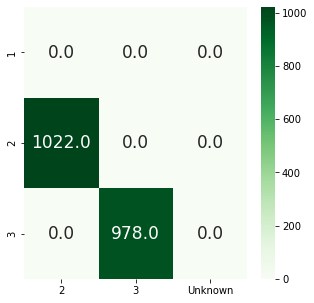

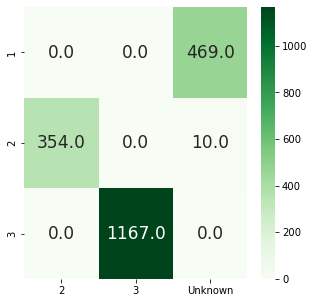

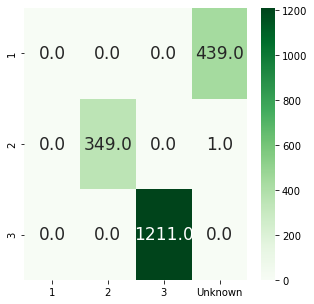

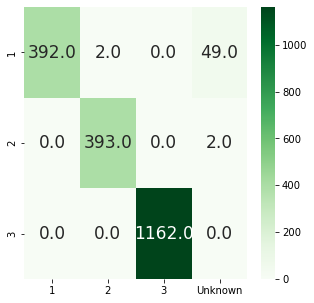

In [34]:
total = len(S1)
#ventana = 0
n_ventana = 0
Time_stamps = [ ]
cero = 0
columns = ['Clase correcta', 'Clasificado en', "Ventana", "GHOS", "STM", 'Acierto']
columns_stm = ['Clase correcta', 'Clasificado en', 'Ventana', "GHOS"]
col_clasif_stm = ['Clase_correcta', 'Clasificado en', 'GHOS', 'Acierto', 'Ventana']
index_no_emerging = []
col_no_emerging = ["Ventana", "Cluster STM", 'clase original', 'clase propuesta', 'error', 'instancias', 'T']
no_emerging = [] 
clases = []
clases_stm = []
clasif_right_stm = []
clasif_wrong_stm = []
index = []
index_stm= []
index_right_stm = []
index_wrong_stm = []
index_time = [] # Para dataframe de tiempo
clasificaciones = []
ghos_stm = []
accuracy_ventana = []
aciertos_clases =[]
aciertos_stm = 0
short_term_memory = pd.DataFrame()
short_classes = pd.DataFrame()

#While para recorrer todo el dataset
print("Así comienzan las clases y sus respectivos clusters.")
print(Cj)
print(num_cluster)

while S1.size != 0:
    for i in tqdm_notebook(range(0, math.ceil(total/paso))):
        clasificados = 0
        print("clasificados: " + str(clasificados))
        aciertos = 0
        window = S1[:paso] #window contiene las instancias de la ventana
        Time_stamps.append(window.index[-1])
        # Aquí las instancias se borran del dataset y se pasan a la ventana
        aux_index = window.index.tolist()
        S1 = S1.drop(aux_index)
        n_ventana = n_ventana + 1
        c_v_tot = [] # Es una lista vacía para almacenar cuantos patrones
        # y a qué clase pertenecen por ventana.  
        c_v_det = [] # Es una lista vacía que almacena la clase de la instancia
        # que está siendo analizada solo si fue clasificada correctamente
        matrix_dic = dic_matrix(C_tot) # Diccionario que almacena las instancias y donde se clasificaron erróneamente.

        print("\n Longitud de ventana: " + str(len(window)))
        ventana_size = len(window)
        TimeInit = timer()

        while window.size != 0:
            # Start nos ayuda a medir el tiempo de inicio de la ventana
            start = timer()
            X_test = window.iloc[[0]].drop(['CLASS'], axis=1)
            y_test = window.iloc[[0]]['CLASS']
            c_v_tot.append(int(y_test)) # Aquí se van almacenando las clases que se presentan en la ventana
            # print(c_v_tot[-1])
            indice = X_test.index.tolist()[0]

            # print("indice" + str(indice))
            # Aquí la instancia a analizar se borra de la ventana
            aux_index = X_test.index.tolist()
            window = window.drop(aux_index)

            ###TIEMPO
            ################### FUNCION GHOS #########################################
            winning_class, winning_cluster, ghos = g_h_o_s(num_cluster, Cj, X_test, 'classification')
            ##########################################################################
            # Tiempo desde que inicia la clasificación
            start_clasif = timer()
            
            if opc_clasif == 1:            
                aciertos_clases, index, clases, aciertos, c_v_det, short_classes, \
                short_term_memory, index_stm, clases_stm, ghos_stm, clasificados = clasification_original(winning_class, \
                aciertos_clases, winning_cluster, y_test, X_test, index, indice,n_ventana, ghos, clases, \
                aciertos, c_v_det, short_classes, short_term_memory, index_stm, clases_stm, ghos_stm, clasificados)
        
                
            if opc_clasif == 2: # Aqui la clasificación debe ser con un umbral de similitud (si se elige el número 2)
                # Umbral similarity puede ser un parámetro de usuario o calculado por algo
                # Umbral_similarity = 30 # round(attributes/len(Cj)) + 1
                # si se cumple la siguiente condición entonces se clasifica
                clasificados, index, clases, c_v_det, aciertos, aciertos_clases, \
                short_classes, short_term_memory, index_stm, clases_stm, ghos_stm, \
                matrix_dic = clasificacion2(Umbral_similarity, clasificados, winning_class, \
                winning_cluster, X_test, indice, y_test, n_ventana, ghos, aciertos, \
                aciertos_clases, short_classes, short_term_memory, index_stm, \
                clases_stm, ghos_stm, matrix_dic)


        # - - - - - 
        ti_stm = timer() # Tiempo inicial del análisis de la stm

        print("Patrones en STM: " + str(len(short_term_memory)) + " al inicio de la ventana")
        # Si cumple la condición, se analiza la STM
        if len(short_term_memory)>= n_elements_stm:
            # Me da las instancias mandadas al short term memory
            instancias_stm = pd.DataFrame(clases_stm, index_stm, columns_stm)   
           # Creación de los clusters en el stm
            Clusters, n_clusters_stm = clusters_stm(short_term_memory, mc_stm)          
            # - - - - - - ANÁLISIS DE LA SHORT TERM MEMORY - - - - - - - - - 
            # Las siguientes 5 líneas hacen referencia a la función que checa si el cluster
            # es o no válido. Si es válido, hace la asignación como extensión de la clase
            # o clase emergente.
            Cj, short_term_memory, num_cluster, ShortCluster,short_classes,\
            aciertos_stm,index_right_stm, clasif_right_stm,index_wrong_stm, \
            clasif_wrong_stm, an_tot_stm = analysis_stm(short_term_memory, short_classes, Clusters,\
            n_clusters_stm,Cj, clases_originales, num_cluster, aciertos_stm,index_right_stm, clasif_right_stm,\
            index_wrong_stm,clasif_wrong_stm, instancias_stm, n_ventana)
            #- - - - - - - - - - - ACTUALIZACIÓN DE LA SHORT TERM MEMORY - - - - - - - - - -
            short_term_memory, short_classes = update_t_s(short_term_memory, short_classes,\
            Time_stamps, ventana_de_olvido)
            # Se eliminan los clusteres que se realizaron en este análisis de la STM
            del Clusters
#- - - - - - - - - - - - ACCURACY - - - - - - - - - - - - - - - - 
        if opc_clasif == 1:
            accuracy_ventana.append([(aciertos/ventana_size)*100])
        else:
            print("Se calculará este accuracy como en MINAS")
            print("aciertos: " + str(aciertos) + ", clasificados: " + str(clasificados))
            accuracy_ventana.append([(aciertos/clasificados)*100])
        
        print("Patrones en STM: " + str(len(short_term_memory)) + " al final de la ventana \n")

        # --- CALCULOS DE TIEMPO ----
        TimeFin = timer()
        ElapseTime = TimeFin - TimeInit #Tiempo 
        print("Tiempo transcurrido: " + str(ElapseTime/60))

        # Clases e instancias TOTALES por ventana
        c_v_tot = clases_en_ventana(c_v_tot)
        c_v_det = clases_en_ventana(c_v_det)
        # Clusteres de cada clase por ventana
        cluster_ventana = clusters_en_ventana(Cj, num_cluster)
        # Las siguientes líneas son para crear un datarfame donde se almacenen los tiempos por ventana
        # Dataframe de clasificaciones
        C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
        Cj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.
        clasificacion = {"Ventana": n_ventana, 'TS': Time_stamps[-1], "Accuracy": \
        accuracy_ventana[-1][0], "Tiempo transcurrido [sec]": ElapseTime} 
        #lista = [55, 54]                      
        aux_A = {}
        aux_B = {}
        aux_C = {}
        # En este for va lo que se repite 1 vez por clase
        for clase in range(len(C_tot)):

            aux_col = {"Instancias presentadas clase_" + str(C_tot_ordenado[clase]): \
            c_v_tot['clase_' + str(C_tot_ordenado[clase])] if c_v_tot.get('clase_' + \
            str(C_tot_ordenado[clase])) else cero}

            aux_col_1 = {"Unknown clase " + str(C_tot_ordenado[clase]): \
            matrix_dic["Unknown clase " + str(C_tot_ordenado[clase])], \
            "Numero de clusters en clase_" + str(C_tot_ordenado[clase]): \
            cluster_ventana['cluster_clase_' + str(C_tot[clase])] 
            if cluster_ventana.get('cluster_clase_' + str(C_tot[clase])) else cero}

            aux_A = {}

            #En este for va lo que se repite varias veces por clase
            # En este cico for van las clasificaciones que se hicieron por cada clase 
            for clase2 in range(len(C_tot)):      

                aux_col_3 = {"Clase "+ str(C_tot_ordenado[clase]) + " predicha en " +\
                str(C_tot_ordenado[clase2]): matrix_dic["clase true " + \
                str(C_tot_ordenado[clase]) + " clasificado en " + str(C_tot_ordenado[clase2])]}
                aux_A = {**aux_A, **aux_col_3} 

            aux_B = {**aux_col, **aux_A, **aux_col_1}
            aux_C = {**aux_C, **aux_B}
        clasificacion = {**clasificacion, **aux_C}
        
        """
        clasificacion = {"Ventana": n_ventana, 'TS': Time_stamps[-1], "Accuracy": \
        accuracy_ventana[-1][0], "Tiempo transcurrido [sec]": ElapseTime} 
        for clase in range(len(C_tot)):
            aux_clasificacion = {"Instancias presentadas clase_" + str(C_tot[clase]): c_v_tot['clase_' + str(C_tot[clase])] 
            if c_v_tot.get('clase_' + str(C_tot[clase])) else cero,\
            "Clasificadas en clase_" + str(C_tot[clase]): c_v_det['clase_' + str(C_tot[clase])]\
            if c_v_det.get('clase_' + str(C_tot[clase])) else cero,\
            "Numero de clusters en clase_" + str(C_tot[clase]):cluster_ventana['cluster_clase_' + str(C_tot[clase])] 
            if cluster_ventana.get('cluster_clase_' + str(C_tot[clase])) else cero}
            clasificacion = {**clasificacion, **aux_clasificacion}
        """
        
        index_time.append(n_ventana) #
        clasificaciones.append(clasificacion)
        
        print("Así quedan las clases y sus respectivos clusters.")
        print(Cj)
        print(num_cluster)
        print(matrix_dic)
        print("Así queda la matriz de confusión")
        imprimir_confussion_matrix(C_tot, Cj, matrix_dic)
        
        print("\n")    
        print("Finalizó la ventana: " + str(n_ventana) + " TimeStamp: " +  str(Time_stamps[-1]) + " t: " + str(ElapseTime) + "[sec]" + ' accuracy ' + str(accuracy_ventana[-1][0]))
        print(" - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ")
    time.sleep(0.1)
    
    # Si la clase 1 aun no aparece en Cj entonces ponemos esos valores iguales a cero

-----
-----
-----

In [35]:
accuracy_ventana

[[100.0], [100.0], [100.0], [99.89738327347357]]

In [36]:
"""
C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
Cj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.

clasificacion = {"Ventana": n_ventana, 'TS': Time_stamps[-1], "Accuracy": \
accuracy_ventana[-1][0], "Tiempo transcurrido [sec]": ElapseTime} 
for clase in range(len(C_tot)):
    aux_clasificacion = {"Instancias presentadas clase_" + str(C_tot_ordenado[clase]):\
    c_v_tot['clase_' + str(C_tot[clase])] if c_v_tot.get('clase_' + str(C_tot_ordenado[clase])) else cero,\
    "Clasificadas en clase_" + str(C_tot_ordenado[clase]): c_v_det['clase_' + str(C_tot_ordenado[clase])]\
    if c_v_det.get('clase_' + str(C_tot_ordenado[clase])) else cero,\
    "Numero de clusters en clase_" + str(C_tot_ordenado[clase]): \
                         
    cluster_ventana['cluster_clase_' + str(C_tot_ordenado[clase])] 
    if cluster_ventana.get('cluster_clase_' + str(C_tot_ordenado[clase])) else cero}
    clasificacion = {**clasificacion, **aux_clasificacion}
"""

'\nC_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.\nCj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.\n\nclasificacion = {"Ventana": n_ventana, \'TS\': Time_stamps[-1], "Accuracy": accuracy_ventana[-1][0], "Tiempo transcurrido [sec]": ElapseTime} \nfor clase in range(len(C_tot)):\n    aux_clasificacion = {"Instancias presentadas clase_" + str(C_tot_ordenado[clase]):    c_v_tot[\'clase_\' + str(C_tot[clase])] if c_v_tot.get(\'clase_\' + str(C_tot_ordenado[clase])) else cero,    "Clasificadas en clase_" + str(C_tot_ordenado[clase]): c_v_det[\'clase_\' + str(C_tot_ordenado[clase])]    if c_v_det.get(\'clase_\' + str(C_tot_ordenado[clase])) else cero,    "Numero de clusters en clase_" + str(C_tot_ordenado[clase]):                          \n    cluster_ventana[\'cluster_clase_\' + str(C_tot_ordenado[clase])] \n    if cluster_ventana.get(\'cluster_clase_\' + str(C_tot_ordenado[clase])) else cero}\n    clasificacion = {**cla

In [37]:
#df_confusion = pd.crosstab(np.array(C_tot), np.array(C_tot), rownames=["True"],colnames=["Predict"])
#df_confusion

In [38]:
#type(C_tot)

In [39]:
#a = np.array(C_tot)
#a

---
---
# Guardar y graficar información
---
---

# Guardar el accuracy

In [40]:
# Importing library 
import csv
# opening the csv file in 'w+' mode 
file = open('accuracy_' + str(cadena) +'.csv', 'w+', newline ='')# writing the data into the file 
with file:     
    write = csv.writer(file) 
    write.writerows(accuracy_ventana) 

In [41]:
Cj

[3, 2, 1]

In [42]:
## accuracy_ventana

# Guardar tiempos

In [43]:
"""
# Dataframe de clasificaciones
C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
Cj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.
clasificacion = {"Ventana": n_ventana, 'TS': Time_stamps[-1], "Accuracy": \
accuracy_ventana[-1][0], "Tiempo transcurrido [sec]": ElapseTime} 
#lista = [55, 54]                      
aux_A = {}
aux_B = {}
aux_C = {}
# En este for va lo que se repite 1 vez por clase
for clase in range(len(C_tot)):
    
    aux_col = {"Instancias presentadas clase_" + str(C_tot_ordenado[clase]): \
    c_v_tot['clase_' + str(C_tot_ordenado[clase])] if c_v_tot.get('clase_' + \
    str(C_tot_ordenado[clase])) else cero}
    
    aux_col_1 = {"Unknown clase " + str(C_tot_ordenado[clase]): \
    matrix_dic["Unknown clase " + str(C_tot_ordenado[clase])], \
    "Numero de clusters en clase_" + str(C_tot_ordenado[clase]): \
    cluster_ventana['cluster_clase_' + str(C_tot[clase])] 
    if cluster_ventana.get('cluster_clase_' + str(C_tot[clase])) else cero
                 cluster_ventana['cluster_clase_' + str(C_tot_ordenado[clase])]}
    
    aux_A = {}
                    
    #En este for va lo que se repite varias veces por clase
    # En este cico for van las clasificaciones que se hicieron por cada clase 
    for clase2 in range(len(C_tot)):      
        
        aux_col_3 = {"Clase "+ str(C_tot_ordenado[clase]) + " predicha en " +\
        str(C_tot_ordenado[clase2]): matrix_dic["clase true " + \
        str(C_tot_ordenado[clase]) + " clasificado en " + C_tot_ordenado[clase2]]}
        aux_A = aux_A + aux_col_3 

    aux_B = {**aux_col, **aux_A, **aux_col_1}
    aux_C = {**aux_C, **aux_B}

clasificacion = {**clasificacion, **aux_C}
print("Así quedan las clasificaciones")
print(clasificacion)
"""

'\n# Dataframe de clasificaciones\nC_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.\nCj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.\nclasificacion = {"Ventana": n_ventana, \'TS\': Time_stamps[-1], "Accuracy": accuracy_ventana[-1][0], "Tiempo transcurrido [sec]": ElapseTime} \n#lista = [55, 54]                      \naux_A = {}\naux_B = {}\naux_C = {}\n# En este for va lo que se repite 1 vez por clase\nfor clase in range(len(C_tot)):\n    \n    aux_col = {"Instancias presentadas clase_" + str(C_tot_ordenado[clase]):     c_v_tot[\'clase_\' + str(C_tot_ordenado[clase])] if c_v_tot.get(\'clase_\' +     str(C_tot_ordenado[clase])) else cero}\n    \n    aux_col_1 = {"Unknown clase " + str(C_tot_ordenado[clase]):     matrix_dic["Unknown clase " + str(C_tot_ordenado[clase])],     "Numero de clusters en clase_" + str(C_tot_ordenado[clase]):     cluster_ventana[\'cluster_clase_\' + str(C_tot[clase])] \n    if cluster_ventana.g

In [44]:
# Dataframe de clasificaciones
C_tot_ordenado = sorted(C_tot, reverse=False) # La lista se arregla de mayor a menor.
Cj_ordenado = sorted(Cj, reverse=False) # La lista se arregla de mayor a menor.
columns_clasificaciones = ["Ventana", 'TS', "Accuracy", "Tiempo transcurrido [sec]"]
#lista = [55, 54]                      
aux_A = []
aux_B = []
aux_C = []
# En este for va lo que se repite 1 vez por clase
for clase in range(len(C_tot)):
    aux_col = ["Instancias presentadas clase_" + str(C_tot_ordenado[clase])]
    aux_col_1 = ["Unknown clase " + str(C_tot_ordenado[clase]), \
    "Numero de clusters en clase_" + str(C_tot_ordenado[clase])]
    aux_A = []
    #En este for va lo que se repite varias veces por clase
    # En este cico for van las clasificaciones que se hicieron por cada clase 
    for clase2 in range(len(C_tot)):      
        aux_col_3 = ["Clase "+ str(C_tot_ordenado[clase]) + " predicha en " + str(C_tot_ordenado[clase2])]
        aux_A = aux_A + aux_col_3
    #B = B + aux_col + A
    aux_B = aux_col + aux_A + aux_col_1
    aux_C = aux_C + aux_B
columns_clasificaciones = columns_clasificaciones + aux_C
print("Así quedan las columnas")
print(columns_clasificaciones)

Así quedan las columnas
['Ventana', 'TS', 'Accuracy', 'Tiempo transcurrido [sec]', 'Instancias presentadas clase_1', 'Clase 1 predicha en 1', 'Clase 1 predicha en 2', 'Clase 1 predicha en 3', 'Unknown clase 1', 'Numero de clusters en clase_1', 'Instancias presentadas clase_2', 'Clase 2 predicha en 1', 'Clase 2 predicha en 2', 'Clase 2 predicha en 3', 'Unknown clase 2', 'Numero de clusters en clase_2', 'Instancias presentadas clase_3', 'Clase 3 predicha en 1', 'Clase 3 predicha en 2', 'Clase 3 predicha en 3', 'Unknown clase 3', 'Numero de clusters en clase_3']


In [45]:
Tiempos = pd.DataFrame(clasificaciones, index_time, columns_clasificaciones)
Tiempos

,Ventana,TS,Accuracy,Tiempo transcurrido [sec],Instancias presentadas clase_1,Clase 1 predicha en 1,Clase 1 predicha en 2,Clase 1 predicha en 3,Unknown clase 1,Numero de clusters en clase_1,...,Clase 2 predicha en 2,Clase 2 predicha en 3,Unknown clase 2,Numero de clusters en clase_2,Instancias presentadas clase_3,Clase 3 predicha en 1,Clase 3 predicha en 2,Clase 3 predicha en 3,Unknown clase 3,Numero de clusters en clase_3
1,1,3999,100.000000,63.659726,0,0,0,0,0,5,...,1022,0,0,5,978,0,0,978,0,0
2,2,5999,100.000000,62.029487,469,0,0,0,469,5,...,354,0,10,5,1167,0,0,1167,0,0
3,3,7999,100.000000,69.151792,439,0,0,0,439,5,...,349,0,1,5,1211,0,0,1211,0,1
4,4,9999,99.897383,70.190309,443,392,2,0,49,5,...,393,0,2,5,1162,0,0,1162,0,1


In [46]:
Tiempos.to_csv('Tiempos_' + str(cadena) +'.csv')

In [47]:
"""
# Dataframe de clasificaciones
columns_clasificaciones = ["Ventana", 'TS', "Accuracy", "Tiempo transcurrido [sec]"]
#lista = [55, 54]                      
for clase in range(len(C_tot)):
    print(C_tot[clase])
    aux_col = ["Instancias presentadas clase_" + str(C_tot[clase]), \
    "Clasificadas en clase_" + str(C_tot[clase]), "Numero de clusters en clase_" + str(C_tot[clase])]
    columns_clasificaciones = columns_clasificaciones + aux_col
columns_clasificaciones 
Tiempos = pd.DataFrame(clasificaciones, index_time, columns_clasificaciones)
Tiempos.to_csv('Tiempos_' + str(cadena) +'.csv')
"""

'\n# Dataframe de clasificaciones\ncolumns_clasificaciones = ["Ventana", \'TS\', "Accuracy", "Tiempo transcurrido [sec]"]\n#lista = [55, 54]                      \nfor clase in range(len(C_tot)):\n    print(C_tot[clase])\n    aux_col = ["Instancias presentadas clase_" + str(C_tot[clase]),     "Clasificadas en clase_" + str(C_tot[clase]), "Numero de clusters en clase_" + str(C_tot[clase])]\n    columns_clasificaciones = columns_clasificaciones + aux_col\ncolumns_clasificaciones \nTiempos = pd.DataFrame(clasificaciones, index_time, columns_clasificaciones)\nTiempos.to_csv(\'Tiempos_\' + str(cadena) +\'.csv\')\n'

---
Graficas
---
---


In [48]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [49]:
DataChunk = list(range(1, n_ventana + 1))

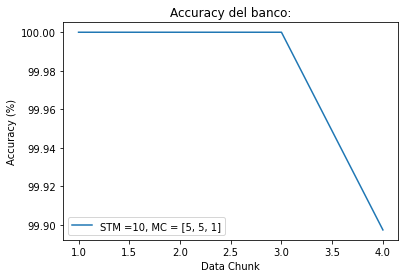

In [50]:
plt.plot(DataChunk, accuracy_ventana, label = "STM =" +str(n_clusters_stm[-1])+ ", MC = " +str(num_cluster))
plt.xlabel('Data Chunk')
plt.ylabel('Accuracy (%)')
plt.title("Accuracy del banco:")
plt.legend()
plt.savefig('Accuracy.jpg')
plt.show()

In [51]:
tiempos = Tiempos['Tiempo transcurrido [sec]']

In [52]:
tiempos = tiempos/60

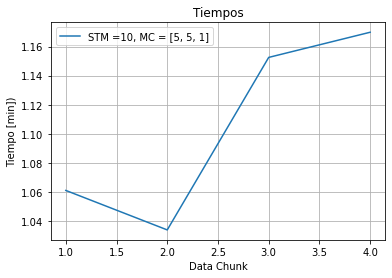

In [53]:
plt.plot(DataChunk, tiempos, label = "STM =" +str(n_clusters_stm[-1])+ ", MC = " +str(num_cluster))
plt.xlabel('Data Chunk')
plt.ylabel('Tiempo [min])')
locs, labels = plt.xticks()  # Get the current locations and labels.
#plt.xticks(np.arange(0, 250, step=20))  # Set label locations.
plt.grid(True)
plt.title("Tiempos")
plt.legend()
plt.savefig('Tiempo_x_ventana.jpg')
plt.show()

# Guardar microclusteres creados

In [54]:
# Se guardan los micro clusteres creados- - MC_j_i -  j es la clase - i el cluster - - - - -
j = 0
n_c = []
for j in range(len(Cj)): # Número de clases
    for i in range(num_cluster[j]): # Número de clusters 
        # Escribir archivos csv
        globals()['MC_'+str(Cj[j])+'_'+str(i+1)].to_csv('MC_'+str(Cj[j])+'_'+str(i+1)+'.csv')

# Guardar los patrones clasificados por el NACOD

In [55]:
# Dataframe de las instancias clasificadas correctamente
patrones_clasificaciones_NACOD = pd.DataFrame(clases, index, columns)
patrones_clasificaciones_NACOD.to_csv('patrones_clasificaciones_NACOD.csv')
patrones_clasificaciones_NACOD

,Clase correcta,Clasificado en,Ventana,GHOS,STM,Acierto
2000,3,3,1,41,no,pasó el umbral
2001,3,3,1,41,no,pasó el umbral
2002,2,2,1,36,no,pasó el umbral
2003,2,2,1,34,no,pasó el umbral
2004,3,3,1,41,no,pasó el umbral
...,...,...,...,...,...,...
9995,3,3,4,41,no,pasó el umbral
9996,3,3,4,41,no,pasó el umbral
9997,2,2,4,41,no,pasó el umbral
9998,3,3,4,41,no,pasó el umbral


# Guardar los patrones mandados a STM

Son todas las instancias que NACOD no pudo clasificar y se fueron a la memoria corta.

In [56]:
# Dataframe del histórico de la información de las instancias que llegaron al
# short term memory durante la ejecución del programa.
patrones_mandados_a_STM = pd.DataFrame(clases_stm, index_stm, columns_stm)
patrones_mandados_a_STM.to_csv('patrones_mandados_a_STM.csv')
patrones_mandados_a_STM

,Clase correcta,Clasificado en,Ventana,GHOS
4003,1,STM,2,29
4005,1,STM,2,28
4014,1,STM,2,30
4017,1,STM,2,29
4019,1,STM,2,30
...,...,...,...,...
9733,1,STM,4,29
9771,1,STM,4,31
9799,1,STM,4,29
9837,1,STM,4,29


# Patrones que se detectaron en extensión o en nueva clase pero que son erroneos.

In [57]:
index_no_emerging = list(range(1,len(no_emerging)+1))
Clases_no_emerging = pd.DataFrame(no_emerging, index_no_emerging, col_no_emerging)
Clases_no_emerging.to_csv('Clusters_desechados.csv')
Clases_no_emerging

,Ventana,Cluster STM,clase original,clase propuesta,error,instancias,T
1,2,1,1,2,extension,76,40758.639731
2,2,2,1,2,extension,64,40758.639731
3,2,4,1,2,extension,86,40758.639731
4,2,5,1,2,extension,50,40758.639731
5,2,7,1,2,extension,58,40758.639731
6,2,8,1,2,extension,49,40758.639731
7,2,10,1,2,extension,73,40758.639731
8,3,1,1,2,extension,61,34960.727472
9,3,2,1,2,extension,105,34960.727472
10,3,7,1,0,emergente,107,4.254067


---
---

In [58]:
# Como queda STM al final del análisis
short_term_memory # STM Actualizado
short_term_memory.to_csv('STM_actualizada.csv')

In [59]:
# Clases correctas de la STM
short_classes # Clases de la STM Actualizadas
short_classes.to_csv('STM_clases_actualizadas.csv')

---
---
---

---
---
---